## Physics Informed Neural Networks for Inverse Problems

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import math
from torch.utils.data import DataLoader
from Common import NeuralNet
import time
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)
import os

In [2]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_
        # @AmrUmeri: Added constants
        self.alpha_f = 0.005
        self.alpha_s = 0.08
        self.h_f = 5
        self.h_s = 6
        self.T_hot = 4
        self.T_cold = 1
        self.T_zero = 1


        # Extrema of the solution domain (t,x) in [0,0.1] x [-1,1]
        self.domain_extrema = torch.tensor([[0, 8],  # Time dimension
                                            [0, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 10

        # FF Dense NN to approximate the solution of the underlying heat equation
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1,
                                              n_hidden_layers=4,
                                              neurons=20,
                                              retrain_seed=42)

        # FF Dense NN to approximate the conductivity we wish to infer
        self.approximate_coefficient = NeuralNet(input_dimension=self.domain_extrema.shape[0],
                                                 output_dimension=1,
                                                 n_hidden_layers=4,
                                                 neurons=20,
                                                 retrain_seed=42)

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int, self.training_set_meas = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]
    
    


    ################################################################################################
    def get_fluid_velocity(self, inputs):
        u_f = torch.full(inputs.shape, 0)
        T_cycle = 4
        for i, t in enumerate(inputs):
            t_cycle = math.floor(t)%T_cycle
            if t_cycle == 0:
                u_f[i] = 1 # Charging Phase
            elif t_cycle == 1:
                u_f[i] = 0  # Idle Phase
            elif t_cycle == 2:
                u_f[i] = -1 # Discharging Phase
            elif t_cycle == 3:
                u_f[i] = 0  # Idle Phase

        return u_f


    
    
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = torch.full(input_tb[:, 0].shape, self.T_zero).reshape(-1,1)

        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.soboleng.draw(self.n_sb)
        
        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)
        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)
        
        ## Input
        # Charging Phase
        input_sb_charge_0 = torch.clone(input_sb_0)
        input_sb_charge_L = torch.clone(input_sb_L)
        input_sb_charge = torch.cat((input_sb_charge_0, input_sb_charge_L), dim=0)
        
        # Discharging Phase
        input_sb_discharge_0 = torch.clone(input_sb_0)
        input_sb_discharge_L = torch.clone(input_sb_L) 
        input_sb_discharge_0[:, 0] = input_sb_discharge_0[:, 0] + 2
        input_sb_discharge_L[:, 0] = input_sb_discharge_L[:, 0] + 2
        input_sb_discharge = torch.cat((input_sb_discharge_0, input_sb_discharge_L), dim=0)
        
        # Idle Phase
        input_sb_idle1_0 = torch.clone(input_sb_0)
        input_sb_idle1_L = torch.clone(input_sb_L) 
        input_sb_idle1_0[:, 0] = input_sb_idle1_0[:, 0] + 1
        input_sb_idle1_L[:, 0] = input_sb_idle1_L[:, 0] + 1
        input_sb_idle1 = torch.cat((input_sb_idle1_0, input_sb_idle1_L), dim=0)
        
        input_sb_idle2_0 = torch.clone(input_sb_0)
        input_sb_idle2_L = torch.clone(input_sb_L) 
        input_sb_idle2_0[:, 0] = input_sb_idle2_0[:, 0] + 3
        input_sb_idle2_L[:, 0] = input_sb_idle2_L[:, 0] + 3
        input_sb_idle2 = torch.cat((input_sb_idle2_0, input_sb_idle2_L), dim=0)
        
        # First Cycle
        cat_input_1 =  torch.cat([input_sb_charge, input_sb_idle1, input_sb_discharge, input_sb_idle2], 0)
        # Second Cycle
        cat_input_2 =  torch.cat([input_sb_charge, input_sb_idle1, input_sb_discharge, input_sb_idle2], 0)
        cat_input_2[:, 0] = cat_input_2[:, 0] + 4
        

        ############################################################
        ## Output
        # Charging Phase
        charge_output_0 = torch.full(input_sb_0[:, 1].shape, self.T_hot).reshape(-1,1)
        charge_output_L = torch.full(input_sb_L[:, 1].shape, 0).reshape(-1,1)
        charge_ouput = torch.cat((charge_output_0, charge_output_L), dim=0)
    
        # Discharging Phase
        discharge_output_0 = torch.full(input_sb_0[:, 1].shape, 0).reshape(-1,1)
        discharge_output_L = torch.full(input_sb_L[:, 1].shape, self.T_cold).reshape(-1,1)
        discharge_output = torch.cat((discharge_output_0, discharge_output_L), dim=0)


        # Idle Phase
        idle_output_0 = torch.full(input_sb_0[:, 1].shape, 0).reshape(-1,1)
        idle_output_L = torch.full(input_sb_L[:, 1].shape, 0).reshape(-1,1)
        idle_output_1 = torch.cat((idle_output_0, idle_output_L), dim=0)
        idle_output_2 = torch.cat((idle_output_0, idle_output_L), dim=0)
        
        
        # First Cycle
        cat_output_1 = torch.cat([charge_ouput, idle_output_1, discharge_output, idle_output_2], 0)
        # Second Cycle
        cat_output_2 = torch.cat([charge_ouput, idle_output_1, discharge_output, idle_output_2], 0)
        
        return torch.cat([cat_input_1.requires_grad_(True), cat_input_2.requires_grad_(True)], 0), torch.cat([cat_output_1, cat_output_2], 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int


    def get_measurement_data(self):
        df_meas = pd.read_csv("Proj1_Y24/Task2/DataSolution.txt")
        tensor_meas = torch.tensor(df_meas.values , dtype=torch.float)
        input_meas = tensor_meas[:, :2]
        output_meas = tensor_meas[:, 2:]
        return input_meas, output_meas


    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()  # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()  # S_int
        input_meas, output_meas = self.get_measurement_data()      # S_meas


        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=16*self.space_dimensions*self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)
        training_set_meas = DataLoader(torch.utils.data.TensorDataset(input_meas, output_meas), batch_size = output_meas.shape[0], shuffle=False)
        
        return training_set_sb, training_set_tb, training_set_int, training_set_meas

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        return u_pred_tb

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb):
        points_per_phase  = int(input_sb.shape[0]/16)
        input_sb_dict = {}
        
        ## Input
        for k in range(16):
            input_sb_dict[k] = input_sb[k*points_per_phase:(k+1)*points_per_phase, :]
            
        # First Cycle
        input_sb_charging_0 = input_sb_dict[0]
        input_sb_charging_L = input_sb_dict[1]
        input_sb_idle_0_1 = input_sb_dict[2]
        input_sb_idle_L_1 = input_sb_dict[3]
        input_sb_discharging_0 = input_sb_dict[4]
        input_sb_discharging_L = input_sb_dict[5]
        input_sb_idle_0_2 = input_sb_dict[6]
        input_sb_idle_L_2 = input_sb_dict[7]
        
        # Second Cycle
        input_sb_charging_0_2 = input_sb_dict[8]
        input_sb_charging_L_2 = input_sb_dict[9]
        input_sb_idle_0_3 = input_sb_dict[10]
        input_sb_idle_L_3 = input_sb_dict[11]
        input_sb_discharging_0_2 = input_sb_dict[12]
        input_sb_discharging_L_2 = input_sb_dict[13]
        input_sb_idle_0_4 = input_sb_dict[14]
        input_sb_idle_L_4 = input_sb_dict[15]
        
        # Get boundary conditions
        # Charging Phase
        # First Cycle
        Tf_sb_0_charging_1 = self.approximate_solution(input_sb_charging_0).reshape(-1,1)
        Tf_sb_L_charging_1 = self.approximate_solution(input_sb_charging_L).reshape(-1,1)
        grad_Tf_sb_L_charging_1 = torch.autograd.grad(Tf_sb_L_charging_1.sum(), input_sb_charging_L, create_graph=True)[0][:, 1].reshape(-1,1)

        # Second Cycle
        Tf_sb_0_charging_2 = self.approximate_solution(input_sb_charging_0_2).reshape(-1,1)
        Tf_sb_L_charging_2 = self.approximate_solution(input_sb_charging_L_2).reshape(-1,1)
        grad_Tf_sb_L_charging_2 = torch.autograd.grad(Tf_sb_L_charging_2.sum(), input_sb_charging_L_2, create_graph=True)[0][:, 1].reshape(-1,1)

        # Discharging Phase
        # First Cycle
        Tf_sb_0_discharging_1 = self.approximate_solution(input_sb_discharging_0).reshape(-1,1)
        grad_Tf_sb_0_discharging_1 = torch.autograd.grad(Tf_sb_0_discharging_1.sum(), input_sb_discharging_0, create_graph=True)[0][:, 1].reshape(-1,1)
        Tf_sb_L_discharging_1 = self.approximate_solution(input_sb_discharging_L).reshape(-1,1)
        
        # Second Cycle
        Tf_sb_0_discharging_2 = self.approximate_solution(input_sb_discharging_0_2).reshape(-1,1)
        grad_Tf_sb_0_discharging_2 = torch.autograd.grad(Tf_sb_0_discharging_2.sum(), input_sb_discharging_0_2, create_graph=True)[0][:, 1].reshape(-1,1)
        Tf_sb_L_discharging_2 = self.approximate_solution(input_sb_discharging_L_2).reshape(-1,1)
        
        # Idle Phase
        # First Cycle
        Tf_sb_0_idle_1 = self.approximate_solution(input_sb_idle_0_1).reshape(-1,1)
        Tf_sb_L_idle_1 = self.approximate_solution(input_sb_idle_L_1).reshape(-1,1)
        grad_Tf_sb_0_idle_1 = torch.autograd.grad(Tf_sb_0_idle_1.sum(), input_sb_idle_0_1, create_graph=True)[0][:, 1].reshape(-1,1) # *
        grad_Tf_sb_L_idle_1 = torch.autograd.grad(Tf_sb_L_idle_1.sum(), input_sb_idle_L_1, create_graph=True)[0][:, 1].reshape(-1,1) # *
        
        Tf_sb_0_idle_2 = self.approximate_solution(input_sb_idle_0_2).reshape(-1,1)
        Tf_sb_L_idle_2 = self.approximate_solution(input_sb_idle_L_2).reshape(-1,1)
        grad_Tf_sb_0_idle_2 = torch.autograd.grad(Tf_sb_0_idle_2.sum(), input_sb_idle_0_2, create_graph=True)[0][:, 1].reshape(-1,1) # *
        grad_Tf_sb_L_idle_2 = torch.autograd.grad(Tf_sb_L_idle_2.sum(), input_sb_idle_L_2, create_graph=True)[0][:, 1].reshape(-1,1) # *

        # Second Cycle
        Tf_sb_0_idle_3 = self.approximate_solution(input_sb_idle_0_3).reshape(-1,1)
        Tf_sb_L_idle_3 = self.approximate_solution(input_sb_idle_L_3).reshape(-1,1)
        grad_Tf_sb_0_idle_3 = torch.autograd.grad(Tf_sb_0_idle_3.sum(), input_sb_idle_0_3, create_graph=True)[0][:, 1].reshape(-1,1) # *
        grad_Tf_sb_L_idle_3 = torch.autograd.grad(Tf_sb_L_idle_3.sum(), input_sb_idle_L_3, create_graph=True)[0][:, 1].reshape(-1,1) # *
        
        Tf_sb_0_idle_4 = self.approximate_solution(input_sb_idle_0_4).reshape(-1,1)
        Tf_sb_L_idle_4 = self.approximate_solution(input_sb_idle_L_4).reshape(-1,1)
        grad_Tf_sb_0_idle_4 = torch.autograd.grad(Tf_sb_0_idle_4.sum(), input_sb_idle_0_4, create_graph=True)[0][:, 1].reshape(-1,1) # *
        grad_Tf_sb_L_idle_4 = torch.autograd.grad(Tf_sb_L_idle_4.sum(), input_sb_idle_L_4, create_graph=True)[0][:, 1].reshape(-1,1) # *

        cat_tensor = torch.cat([Tf_sb_0_charging_1, grad_Tf_sb_L_charging_1, grad_Tf_sb_0_idle_1, grad_Tf_sb_L_idle_1, grad_Tf_sb_0_discharging_1, Tf_sb_L_discharging_1,  grad_Tf_sb_0_idle_2, grad_Tf_sb_L_idle_2,
            Tf_sb_0_charging_2, grad_Tf_sb_L_charging_2, grad_Tf_sb_0_idle_3, grad_Tf_sb_L_idle_3 , grad_Tf_sb_0_discharging_2, Tf_sb_L_discharging_2, grad_Tf_sb_0_idle_4, grad_Tf_sb_L_idle_4
        ], 0)

        return cat_tensor
        
        

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        Tf = self.approximate_solution(input_int).reshape(-1,)
        Ts = self.approximate_coefficient(input_int).reshape(-1,)
        
        grad_tf = torch.autograd.grad(Tf.sum(), input_int, create_graph=True)[0]
        grad_tf_t = grad_tf[:,0]
        grad_tf_x = grad_tf[:,1]
        
        grad_tf_xx = torch.autograd.grad(grad_tf_x.sum(), input_int, create_graph=True)[0][:,1]
        
        u_f = self.get_fluid_velocity(input_int[:, 0])

        residual = (grad_tf_t+u_f*grad_tf_x)-(self.alpha_f*grad_tf_xx-self.h_f*(Tf-Ts))
        return residual.reshape(-1, )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, inp_train_meas, u_train_meas, verbose=True):

        u_pred_sb = self.apply_boundary_conditions(inp_train_sb)
        u_pred_tb = self.apply_initial_condition(inp_train_tb)
        u_pred_meas = self.approximate_solution(inp_train_meas) 

        assert (u_pred_sb.shape[1] == u_train_sb.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])
        assert (u_pred_meas.shape[1] == u_train_meas.shape[1])

        r_int = self.compute_pde_residual(inp_train_int)
        r_sb = u_train_sb - u_pred_sb
        r_tb = u_train_tb - u_pred_tb
        r_meas = u_train_meas - u_pred_meas

        loss_sb = torch.mean(abs(r_sb) ** 2)
        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)
        loss_meas = torch.mean(abs(r_meas) ** 2)

        loss_u = loss_sb + loss_tb + loss_meas

        loss = torch.log10(self.lambda_u * loss_u + loss_int)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_int).item(), 4), "| Function Loss: ", round(torch.log10(loss_u).item(), 4))

        return loss
    
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int), (inp_train_data, u_train_data)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int, self.training_set_meas)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, inp_train_data, u_train_data, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history



Let us test the code:




In [3]:
n_int = 128
n_sb = 64
n_tb = 64

pinn = Pinns(n_int, n_sb, n_tb)

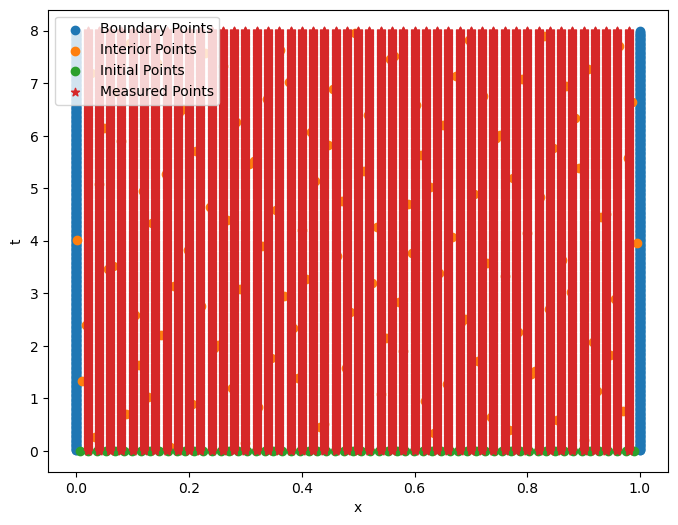

In [4]:
# Plot the input training points
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()
input_meas_, output_meas_ = pinn.get_measurement_data()

plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Interior Points")
plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")
plt.scatter(input_meas_[:, 1].detach().numpy(), input_meas_[:, 0].detach().numpy(), label="Measured Points", marker="*")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

In [5]:
n_epochs = 5
max_iter = 20000
optimizer_LBFGS = optim.LBFGS(list(pinn.approximate_solution.parameters()) + list(pinn.approximate_coefficient.parameters()),
                              lr=float(0.5),
                              max_iter=max_iter,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)

optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.005))

In [6]:
input_meas, exact_meas = Pinns.get_measurement_data(pinn)
print(pinn.approximate_solution((input_meas)))

tensor([[ 0.0108],
        [ 0.0446],
        [ 0.0779],
        ...,
        [-0.0017],
        [-0.0015],
        [-0.0013]], grad_fn=<AddmmBackward0>)


In [7]:
hist = Pinns.fit(pinn,
          num_epochs=n_epochs,
          optimizer=optimizer_LBFGS,
          verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

################################  0  ################################
Total loss:  1.6793 | PDE Loss:  -0.3156 | Function Loss:  0.6749
Total loss:  1.6181 | PDE Loss:  -0.0228 | Function Loss:  0.6081
Total loss:  1.4394 | PDE Loss:  0.7497 | Function Loss:  0.3401
Total loss:  1.3976 | PDE Loss:  0.6361 | Function Loss:  0.315
Total loss:  1.1996 | PDE Loss:  -0.1296 | Function Loss:  0.1788
Total loss:  1.1159 | PDE Loss:  -0.2926 | Function Loss:  0.0986
Total loss:  1.1104 | PDE Loss:  -0.3713 | Function Loss:  0.0958
Total loss:  1.1074 | PDE Loss:  -0.4038 | Function Loss:  0.0938
Total loss:  1.1007 | PDE Loss:  -0.4415 | Function Loss:  0.0881
Total loss:  1.0933 | PDE Loss:  -0.5004 | Function Loss:  0.0821
Total loss:  1.0858 | PDE Loss:  -0.4987 | Function Loss:  0.0743
Total loss:  1.0756 | PDE Loss:  -0.5311 | Function Loss:  0.0647
Total loss:  1.0678 | PDE Loss:  -0.5504 | Function Loss:  0.0572
Total loss:  1.062 | PDE Loss:  -0.5913 | Function Loss:  0.0523
Total loss

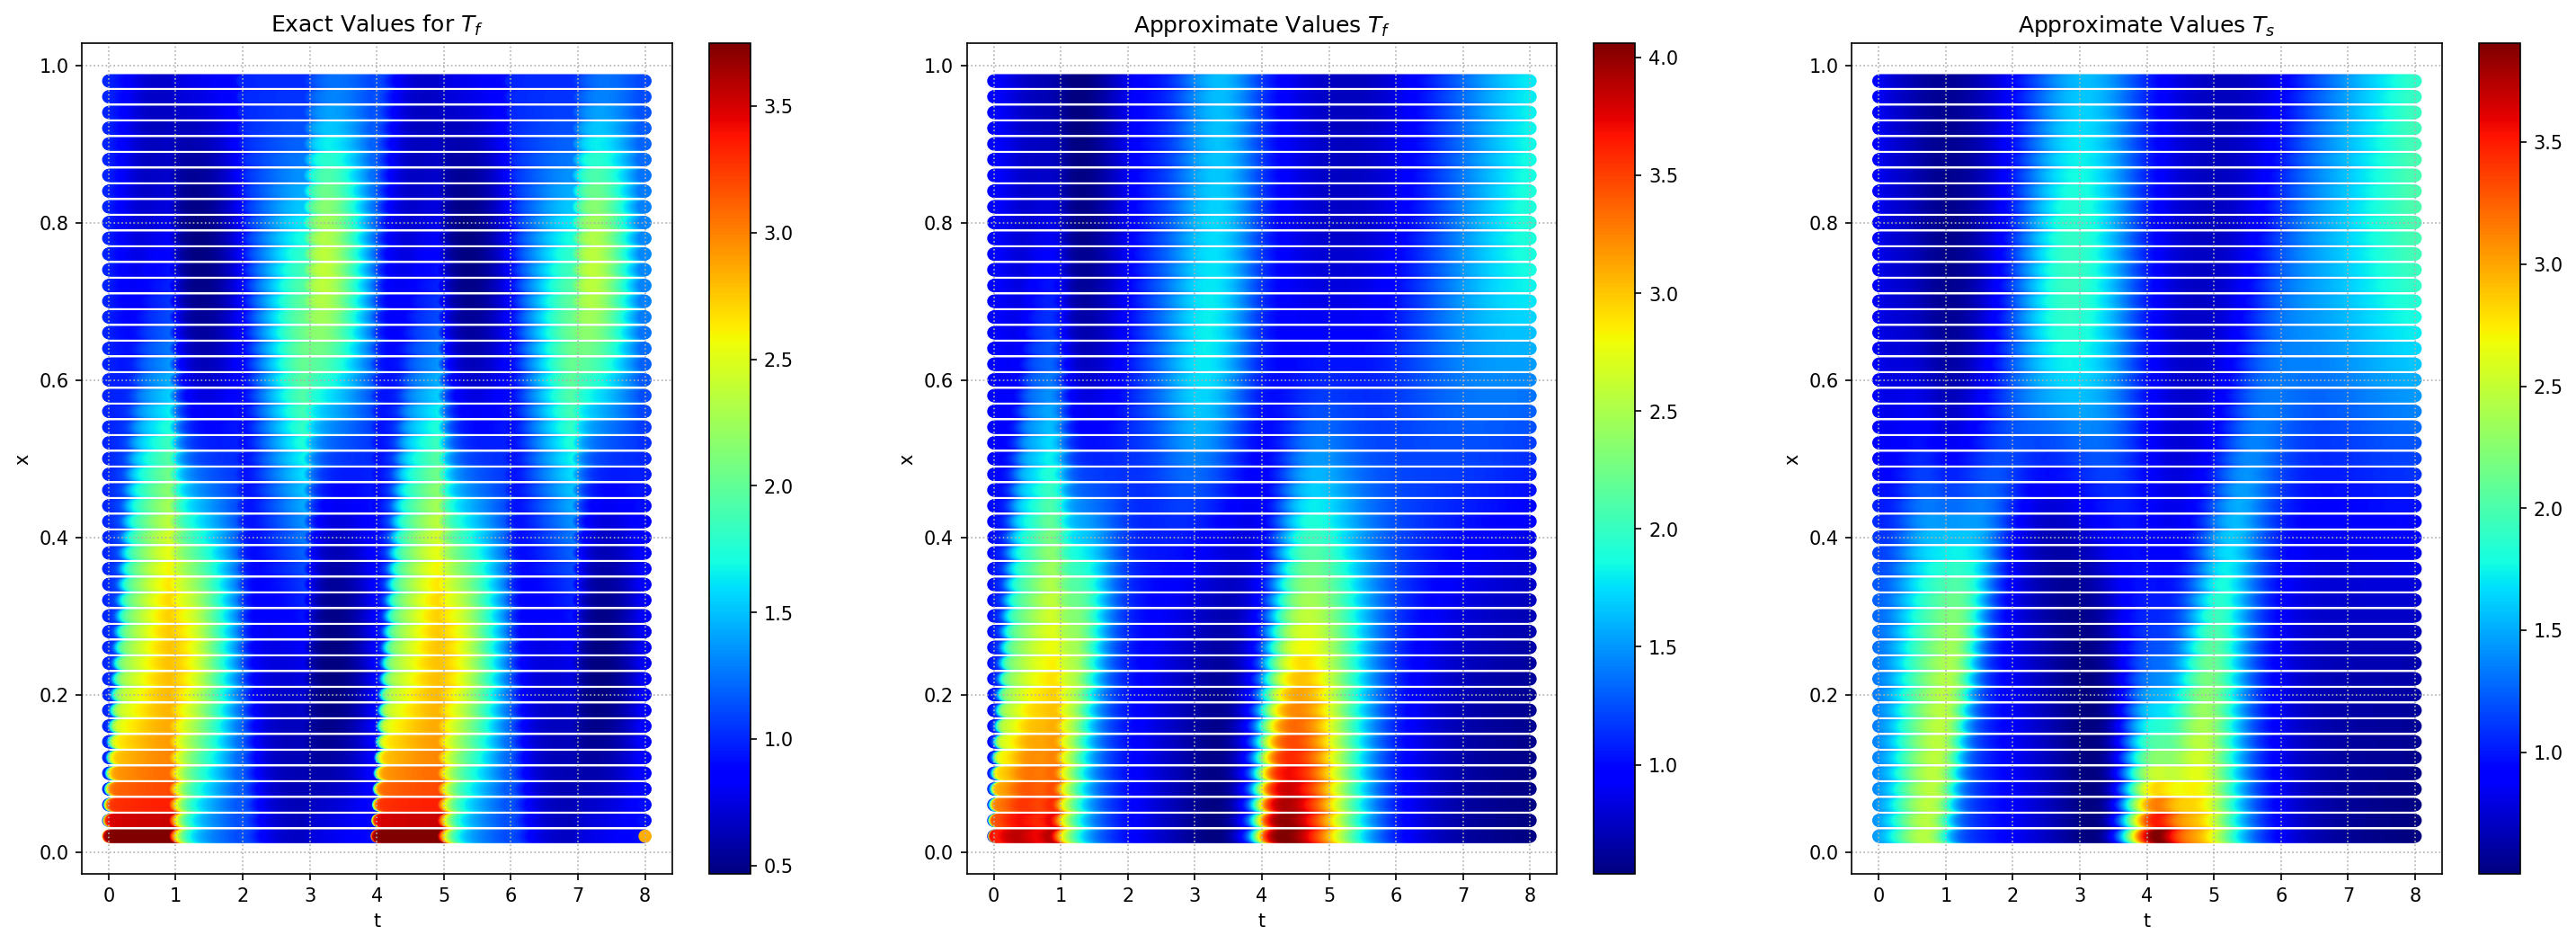

In [ ]:
input_meas, exact_meas = Pinns.get_measurement_data(pinn)

# Plot the predictions vs the exact solutions
fig, axs = plt.subplots(1, 3, figsize=(24, 8), dpi=150)
im1 = axs[0].scatter(input_meas[:, 0].detach(), input_meas[:, 1].detach(), c=exact_meas.detach(), cmap='jet')
axs[0].set_xlabel("t")
axs[0].set_ylabel("x")
axs[0].set_title("Exact Values for $T_f$")
plt.colorbar(im1, ax=axs[0])
axs[0].grid(True, which="both", ls=":")


prediction_meas_tf = pinn.approximate_solution(input_meas).reshape(-1, )
prediction_meas_ts = pinn.approximate_coefficient(input_meas).reshape(-1, )


im2 = axs[1].scatter(input_meas[:, 0].detach(), input_meas[:, 1].detach(), c=prediction_meas_tf.detach(), cmap="jet")
axs[1].set_xlabel("t")
axs[1].set_ylabel("x")
plt.colorbar(im2, ax=axs[1])
axs[1].grid(True, which="both", ls=":")

axs[1].set_title("Approximate Values $T_f$")

im3 = axs[2].scatter(input_meas[:, 0].detach(), input_meas[:, 1].detach(), c=prediction_meas_ts.detach(), cmap="jet")
axs[2].set_xlabel("t")
axs[2].set_ylabel("x")
plt.colorbar(im3, ax=axs[2])
axs[2].grid(True, which="both", ls=":")

axs[2].set_title("Approximate Values $T_s$")

fig.savefig("./Task2_Exact_Approximate_Solution.png")


In [ ]:

test_data, outputdata = Pinns.get_measurement_data(pinn)
prediction_Ts = pinn.approximate_coefficient(test_data)
prediction_Ts

tensor([[1.4320],
        [1.4387],
        [1.4457],
        ...,
        [1.8712],
        [1.8756],
        [1.8800]], grad_fn=<AddmmBackward0>)

In [ ]:
test_pred = pd.read_csv("Proj1_Y24/Task2/DataSolution.txt")
test_pred['ts'] = prediction_Ts.detach()
test_pred.drop(columns = ["tf"], inplace=  True)
display(test_pred)


test_pred.to_csv("task2.txt", header=True, index=None, sep=',', mode='w')

,t,x,ts
0,0.000000,0.02,1.431964
1,0.010013,0.02,1.438730
2,0.020025,0.02,1.445706
3,0.030038,0.02,1.452885
4,0.040050,0.02,1.460279
...,...,...,...
39195,7.959950,0.98,1.862297
39196,7.969963,0.98,1.866732
39197,7.979975,0.98,1.871162
39198,7.989988,0.98,1.875586


In [ ]:
df_meas = pd.read_csv("Proj1_Y24/Task2/DataSolution.txt")
tensor_meas = torch.tensor(df_meas.values , dtype=torch.float)
input_meas = tensor_meas[:, :2]
output_meas = tensor_meas[:, 2:]

In [ ]:
display(input_meas)

tensor([[0.0000, 0.0200],
        [0.0100, 0.0200],
        [0.0200, 0.0200],
        ...,
        [7.9800, 0.9800],
        [7.9900, 0.9800],
        [8.0000, 0.9800]])